In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

from tqdm import tqdm

torch.manual_seed(42)

In [2]:
def find_mean_std(dataset):
    channel_means, channel_stds = 0, 0
    for img, _ in dataset:
        channel_means += torch.mean(img, dim=(1, 2))
        channel_stds += torch.std(img, dim=(1, 2))
    channel_means /= len(dataset)
    channel_stds /= len(dataset)
    return channel_means, channel_stds

In [3]:
transform_mnist = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),             
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.2821, 0.2821, 0.2821))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 44580910.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1620067.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13336980.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2241766.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
cifar_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.4923, 0.4831, 0.4474), (0.1943, 0.1915, 0.1932))
])

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 56763606.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class MixedDataset(Dataset):
    def __init__(self, mnist, cifar, transform=None):
        self.mnist = mnist
        self.cifar = cifar
        self.transform = transform

    def __len__(self):
        return min(len(self.mnist), len(self.cifar))

    def __getitem__(self, idx):
        mnist_img, _ = self.mnist[idx]
        cifar_img, _ = self.cifar[idx]

        if self.transform:
            mnist_img = self.transform(mnist_img)
            cifar_img = self.transform(cifar_img)

        mean_img = (mnist_img + cifar_img) / 2
        return mean_img, mnist_img, cifar_img

In [6]:
mixed_dataset_train = MixedDataset(mnist_train, cifar_train)
train_dataloader = DataLoader(mixed_dataset_train, batch_size=64, shuffle=True)

mixed_dataset_test = MixedDataset(mnist_test, cifar_test)
test_dataloader = DataLoader(mixed_dataset_test, batch_size=64, shuffle=True)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        return self.relu(out)

class ImageGenerator(nn.Module):
    def __init__(self, input_image_size=64):
        super(ImageGenerator, self).__init__()
        
        self.input_image_size = input_image_size

        # CNN for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the size of the flattened features
        self.flatten_size = 128 * (input_image_size // 8) * (input_image_size // 8)

        # Fully connected layers for processing features
        self.fc1 = nn.Sequential(
            nn.Linear(self.flatten_size, self.flatten_size),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.flatten_size, self.flatten_size),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Convolutional layers after upsampling to generate first output image
        self.upconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.upconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.upconv3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.final_conv1 = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)

        # Convolutional layers after upsampling to generate second output image with Residual Blocks
        self.upconv4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.resblock1 = ResidualBlock(64)
        self.upconv5 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.resblock2 = ResidualBlock(32)
        self.upconv6 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.resblock3 = ResidualBlock(16)
        self.final_conv2 = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        batch_size = x.size(0)

        # Extract features using CNN
        x = self.cnn(x)
        x = x.view(batch_size, -1)

        # Process features through fully connected layers
        features1 = self.fc1(x)
        features2 = self.fc2(x)

        # Reshape features to prepare for upsampling
        features1 = features1.view(batch_size, 128, self.input_image_size // 8, self.input_image_size // 8)
        features2 = features2.view(batch_size, 128, self.input_image_size // 8, self.input_image_size // 8)

        # Generate the first image
        img1 = self.upconv1(features1)
        img1 = self.upconv2(img1)
        img1 = self.upconv3(img1)
        img1 = self.final_conv1(img1)

        # Generate the second image with residual blocks
        img2 = self.upconv4(features2)
        img2 = self.resblock1(img2)
        img2 = self.upconv5(img2)
        img2 = self.resblock2(img2)
        img2 = self.upconv6(img2)
        img2 = self.resblock3(img2)
        img2 = self.final_conv2(img2)

        return img1, img2

In [8]:
class ImageLoss(nn.Module):
    def __init__(self):
        super(ImageLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, output1, output2, target1, target2):
        loss1 = self.mse_loss(output1, target1)
        loss2 = self.mse_loss(output2, target2)
        total_loss = loss1 + loss2
        return total_loss

In [9]:
def train(model, criterion, optimizer, train_dataloader):
    cost = 0
    model.train()
    for mean_img, mnist_img, cifar_img in train_dataloader:
        mean_img, mnist_img, cifar_img = mean_img.to(DEVICE), mnist_img.to(DEVICE), cifar_img.to(DEVICE)
        img1, img2 = model(mean_img)
        loss = criterion(img1, img2, mnist_img, cifar_img)
        cost += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return cost/len(train_dataloader)

In [10]:
def evaluation(model, criterion, eval_dataloader):
    cost = 0
    model.eval()
    for mean_img, mnist_img, cifar_img in eval_dataloader:
        mean_img, mnist_img, cifar_img = mean_img.to(DEVICE), mnist_img.to(DEVICE), cifar_img.to(DEVICE)
        with torch.no_grad():
            img1, img2 = model(mean_img)
            loss = criterion(img1, img2, mnist_img, cifar_img)
            cost += loss.item()
    return cost/len(eval_dataloader)

In [11]:
def run_over_epochs(model, criterion, optimizer, train_dataloader, eval_dataloader):
    history = {"train_loss":[], "eval_loss":[]}
    for _ in tqdm(range(EPOCHS)):
        history["train_loss"].append(train(model, criterion, optimizer, train_dataloader))
        history["eval_loss"].append(evaluation(model, criterion, eval_dataloader))
    return history

In [12]:
def plot_history(history):
    fig, ax = plt.subplots()
    x_axis = range(1, EPOCHS + 1)
    ax.plot(x_axis, history["train_loss"], label="Train Loss")
    ax.plot(x_axis, history["eval_loss"], label="Eval Loss")
    ax.legend();

In [13]:
def plot_images():
    # Fetching sample images from the training data loader
    mean_img, mnist_img, cifar_img = next(iter(train_dataloader))
    mean_img, mnist_img, cifar_img = mean_img.to(DEVICE), mnist_img.to(DEVICE), cifar_img.to(DEVICE)
    

    # Generating reconstructed images using the trained model
    with torch.no_grad():
        reconstructed_mnist_img, reconstructed_cifar_img = model(mean_img)

    # Convert torch tensors to numpy arrays for visualization
    reconstructed_mnist_np = reconstructed_mnist_img.cpu().numpy()[0]
    reconstructed_cifar_np = reconstructed_cifar_img.cpu().numpy()[0]

    # Undo normalization for the reconstructed MNIST image
    mnist_std_dev = np.array([0.2821])
    mnist_mean = np.array([0.1307])
    reconstructed_mnist_np = (reconstructed_mnist_np * mnist_std_dev) + mnist_mean
    mnist_np = (mnist_img.cpu().numpy() * mnist_std_dev) + mnist_mean

    # Undo normalization for the reconstructed CIFAR-10 image
    cifar_std_dev = np.array([[0.1943], [0.1915], [0.1932]]).reshape(3, 1, 1)
    cifar_mean = np.array([[0.4923], [0.4831], [0.4474]]).reshape(3, 1, 1)
    reconstructed_cifar_np = (reconstructed_cifar_np * cifar_std_dev) + cifar_mean
    cifar_np = (cifar_img.cpu().numpy() * cifar_std_dev) + cifar_mean

    # Transpose the numpy arrays to the correct shape for visualization
    reconstructed_mnist_np = np.transpose(reconstructed_mnist_np, (1, 2, 0))
    mnist_np = np.transpose(mnist_np[0], (1, 2, 0))
    reconstructed_cifar_np = np.transpose(reconstructed_cifar_np, (1, 2, 0))
    cifar_np = np.transpose(cifar_np[0], (1, 2, 0))

    # Plotting images
    fig, axes = plt.subplots(2, 2)

    axes[0][0].imshow(mnist_np)
    axes[0][0].set_title('MNIST Image')
    axes[0][0].axis('off')

    axes[0][1].imshow(reconstructed_mnist_np)
    axes[0][1].set_title('Reconstructed MNIST Image')
    axes[0][1].axis('off')

    axes[1][0].imshow(cifar_np)
    axes[1][0].set_title('CIFAR-10 Image')
    axes[1][0].axis('off')

    axes[1][1].imshow(reconstructed_cifar_np)
    axes[1][1].set_title('Reconstructed CIFAR-10 Image')
    axes[1][1].axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 50


model = ImageGenerator().to(DEVICE)
criterion = ImageLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = run_over_epochs(model, criterion, optimizer, train_dataloader, test_dataloader)
torch.save(model, "model.pth")

100%|██████████| 50/50 [1:20:48<00:00, 96.97s/it]


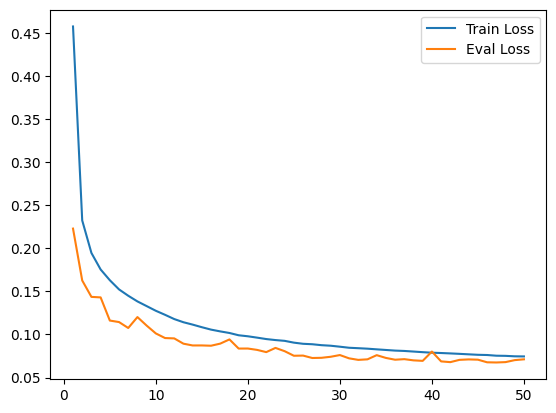

In [15]:
plot_history(history)

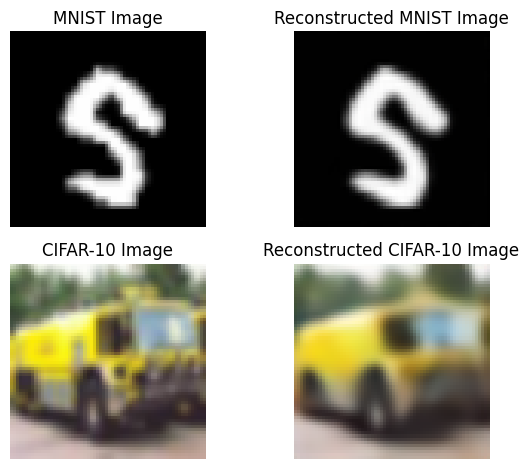

In [16]:
plot_images()

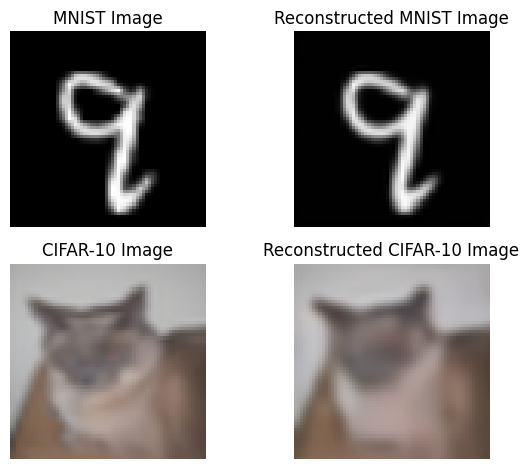

In [17]:
plot_images()

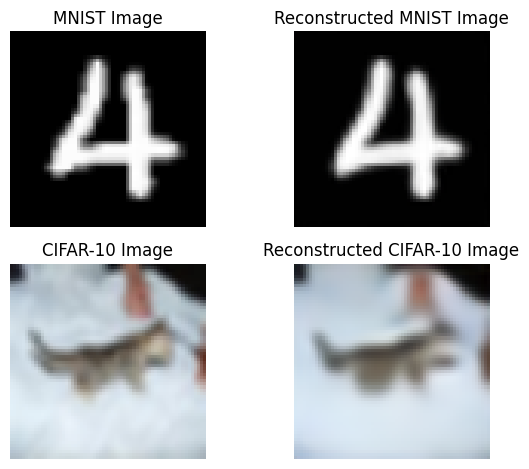

In [18]:
plot_images()